In [7]:
import numpy as np
from util import load_hypocenters, PuuOo, load_puuoo_eqs, prune_data, GetTimeToEruption, GetTimeSinceEruption, GetEQRates
from matplotlib import pyplot as plt
import datetime
from sklearn import ensemble as ml_models

%matplotlib inline

# import data

In [8]:
def GetEastRiftZoneEQs (lat, lon):
    latpts = np.array([19.3,19.5])
    lonpts = np.array([-155.5,-155])
    A      = np.array([lonpts,[1,1]]).T
    line   = np.linalg.solve(A, latpts)
    
    croplocs = lat - line[0]*lon - line[1]
        
    inds = [j for j in range(len(lon)) if croplocs[j]<=0]
       
    return inds



In [9]:
eruption_csv_path = 'PuuOo.csv'
eq_csv_path       = 'puuoo_earthquakes.csv' 

PuuOOLoc = [-155.1050, 19.3864]

p = PuuOo(eruption_csv_path)
time0, lat0, lon0, depth0, mag0 = load_puuoo_eqs(eq_csv_path)
inds = GetEastRiftZoneEQs(lat0, lon0)
print(len(inds))

time = [time0[j] for j in range(len(inds))]
lat  = lat0[inds]
lon  = lon0[inds]
depth= depth0[inds]
mag  = mag0[inds]

tnum = np.array([t.timestamp() for t in time])
erupt = np.array([p.was_erupting(t) for t in time])

3764


In [10]:
print(lat.shape, lon.shape)

(3764,) (3764,)


In [11]:
SecsToEruption = GetTimeToEruption(time, p)
SecsSinceEruption = GetTimeSinceEruption(time, p)
EQsLastDay, EQsLastWeek, EQsLastMonth = GetEQRates(time)

print(np.min(SecsToEruption[SecsToEruption!=0]))

240.0


## plot the data

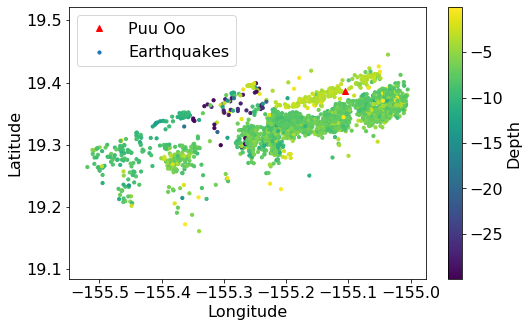

In [12]:

plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(8,5))
plt.scatter(lon, lat, 10, -depth, label='Earthquakes')
plt.plot(PuuOOLoc[0], PuuOOLoc[1], 'r^', label='Puu Oo')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Depth')
plt.axis('equal')
plt.savefig('KilaueaEQs.png')
plt.show()


In [60]:
def GetFreqMagnitude(mag):
    """Returns frequency-magnitude distribution"""

    MaxMag = np.ceil(mag.max())
    MinMag = np.floor(mag.min())

    nfreq, magbins = np.histogram(mag, bins=np.arange(MinMag, MaxMag + 1))
    magbins = np.delete(magbins, -1)
    freq = np.flipud(np.cumsum(np.flipud(nfreq)))

    G = np.zeros((len(freq), 2))
    G[:, 0] = 1
    G[:, 1] = -magbins

    model, residuals, rank, s = np.linalg.lstsq(G, np.log10(freq))
    freq_predict = np.power(10, np.dot(G, model))

    plt.figure(figsize=(6,4))
    plt.semilogy(magbins, freq, 'bx', linewidth=2)
    plt.semilogy(magbins, freq_predict, 'r-', linewidth=2)
    plt.xlabel('magnitude')
    plt.ylabel('# eqs >= magnitude')
    plt.savefig('FrequencyMagnitude')

    return model


/Users/yqwong/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  from ipykernel import kernelapp as app


array([4.74748791, 0.91743933])

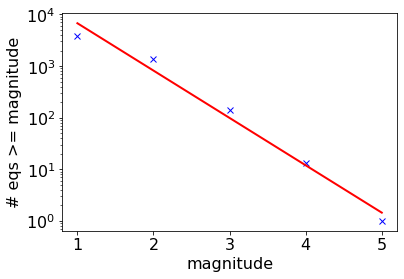

In [61]:
GetFreqMagnitude(mag)

## Prepare data for machine learning

In [15]:
from sklearn import preprocessing

X = np.vstack((lon, lat, depth, mag, EQsLastDay, EQsLastWeek, EQsLastMonth)).T
X = preprocessing.scale(X)
Y = np.array([1 if val==True else 0 for val in erupt])

print(sum(Y)/len(Y))
print(X.shape, Y.shape)

0.1548884165781084
(3764, 7) (3764,)


## Separate data into train and test set

In [16]:
train_idx = np.loadtxt('train.txt', dtype='int')
val_idx = np.loadtxt('dev.txt', dtype='int')
test_idx = np.loadtxt('test.txt', dtype='int')

x_train = X[train_idx,:]
x_val   = X[val_idx,:]
x_test  = X[test_idx,:]

y_train = Y[train_idx]
y_val   = Y[val_idx]
y_test  = Y[test_idx]


(2633, 7) (752, 7) (379, 7)
(2633,) (752,) (379,)


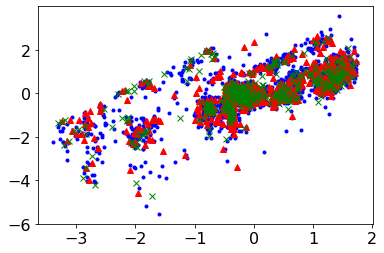

In [17]:
print(x_train.shape, x_val.shape, x_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

plt.figure()
plt.plot(x_train[:,0], x_train[:,1], 'b.', label='training')
plt.plot(x_val[:,0], x_val[:,1], 'r^', label='dev')
plt.plot(x_test[:,0], x_test[:,1], 'gx', label='test')


In [18]:
from sklearn import metrics

def PrintMetrics (labels_true, labels_hat):
    print(metrics.confusion_matrix(labels_true, labels_hat))
    print(metrics.cohen_kappa_score(labels_true, labels_hat))
    print(metrics.roc_auc_score(labels_true, labels_hat))

## start machine learning!

### Run a logistic regression

In [20]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(random_state=0,solver='lbfgs').fit(x_train, y_train)

print(np.all(yhat==0))
print('Naive model on test set:')
PrintMetrics(y_test, np.zeros(y_test.shape))

print('\n Training')
PrintMetrics(y_train, lr.predict(x_train))

print('\n Dev')
PrintMetrics(y_val, lr.predict(x_val))

print('\n test')
PrintMetrics(y_test, lr.predict(x_test))


NameError: name 'yhat' is not defined

## try k means

In [21]:
from sklearn.cluster import KMeans

In [22]:
def CalcDistancesPerCluster (data):
    NumClusters = np.arange(2,50)
    distOut = np.zeros(NumClusters.shape)
    
    for nci in range(NumClusters.shape[0]):
        km = KMeans(init='k-means++', n_clusters=NumClusters[nci], n_init=10)
        km.fit(data)
        distOut[nci] = km.inertia_
        
    return NumClusters, distOut

In [23]:
def GetNearestCentroid(x, cc, label):
    cval = [np.argmin(np.linalg.norm(x[i,:]-cc, axis=1)) for i in range(x.shape[0])]
    LabelOut = label[cval]
    
    return cval, LabelOut

### calculate cluster centroids for erupting and non-erupting cases separately

In [24]:
# first find ideal number of clusters for each set

xNoErupt = x_train[y_train==0,:]
xErupt   = x_train[y_train==1,:]

NclNoErupt, distNoErupt = CalcDistancesPerCluster(xNoErupt)
NclErupt, distErupt = CalcDistancesPerCluster(xErupt)


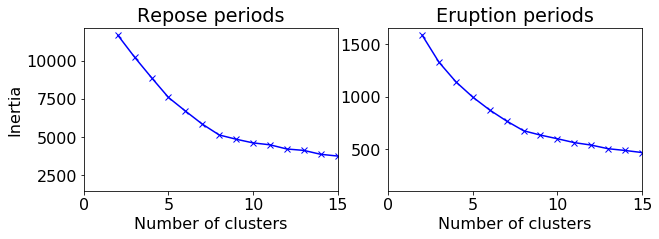

In [35]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(NclNoErupt, distNoErupt, 'bx-')
plt.title('Repose periods')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xlim(0,15)

plt.subplot(122)
plt.plot(NclErupt, distErupt, 'bx-')
plt.title('Eruption periods')
plt.xlabel('Number of clusters')
plt.xlim(0,15)

plt.savefig('ClusterElbow_Class')
plt.show()

ideal number of clusters is around 8 for clustering based on all attributes except seconds to eruption. Now cluster each part separately

In [36]:
NclIdealNoErupt = 8
NclIdealErupt = 2

kmNoErupt = KMeans(init='k-means++', n_clusters=NclIdealNoErupt, n_init=10)
kmNoErupt.fit(xNoErupt)

kmErupt = KMeans(init='k-means++', n_clusters=NclIdealErupt, n_init=10)
kmErupt.fit(xErupt)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [37]:
ccAll = np.concatenate((kmNoErupt.cluster_centers_, kmErupt.cluster_centers_))
labelsErupt = np.concatenate((np.zeros(NclIdealNoErupt), np.ones(NclIdealErupt)))
print(labelsErupt)


print('\n Training')
cval, ytrainkm10 = GetNearestCentroid(x_train, ccAll, labelsErupt)
PrintMetrics(y_train, ytrainkm10)

print('\n Dev')
cval, yvalkm10 = GetNearestCentroid(x_val, ccAll, labelsErupt)
PrintMetrics(y_val, yvalkm10)

print('\n test')
cval, ytestkm10 = GetNearestCentroid(x_test, ccAll, labelsErupt)
PrintMetrics(y_test, ytestkm10)




[0. 0. 0. 0. 0. 0. 0. 0. 1. 1.]

 Training
[[1899  311]
 [ 219  204]]
0.3139399743567558
0.6707727608228234

 Dev
[[556  91]
 [ 55  50]]
0.2934059286146401
0.667770663133878

 test
[[276  48]
 [ 32  23]]
0.240937312237132
0.635016835016835


### Now use kmeans to predict seconds to eruption . and calculate distances per cluster 

In [38]:
# rescale the seconds to eruption

TimeToEruptionScaled = preprocessing.scale(SecsToEruption)
xkm = np.vstack((x_train.T, TimeToEruptionScaled[train_idx])).T


In [39]:
Nclust, dist = CalcDistancesPerCluster(xkm)

plt.figure(figsize=(5,3))
plt.plot(Nclust, dist, 'bx-')
plt.plot(np.array([10,10]), plt.ylim(), 'r-')
plt.xlim(0,40)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.savefig('ClusterElbow.png')
plt.show()

KeyboardInterrupt: 

ideal number of clusters is about 10

In [40]:
NclIdeal=10
kmTime = KMeans(init='k-means++', n_clusters=NclIdeal, n_init=10)
kmTime.fit(xkm)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [41]:
def CalcRMS (diff):
    rms = np.sqrt(np.mean(diff**2))
    print('rms = ', rms)
    return rms


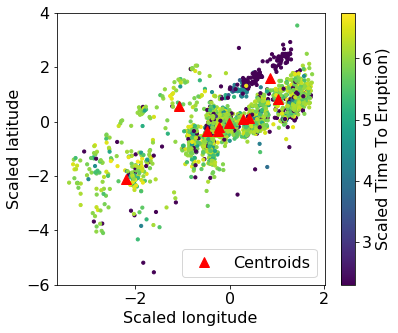

In [54]:
plt.figure(figsize=(6,5))
SecsToEruption[SecsToEruption == 0] = 200
TimeToER = np.log10(SecsToEruption)

plt.scatter(xkm[:,0], xkm[:,1], 10, TimeToER[train_idx])
plt.plot(kmTime.cluster_centers_[:,0], kmTime.cluster_centers_[:,1], 'r^', label='Centroids', markersize=10)
plt.xlabel('Scaled longitude')
plt.ylabel('Scaled latitude')
plt.colorbar(label='Scaled Time To Eruption)')
plt.legend(loc = 'lower right')
plt.savefig('ClusteringMap.png')
plt.show()



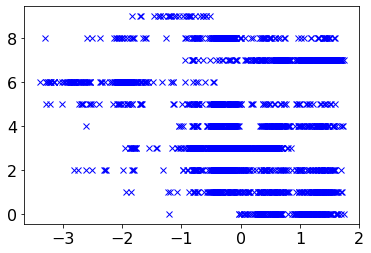

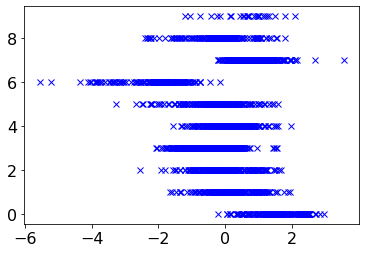

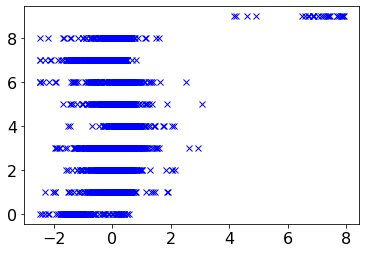

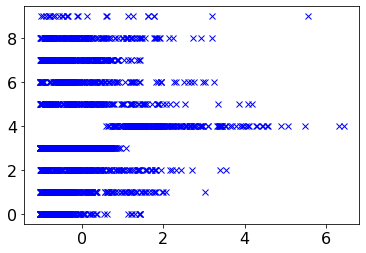

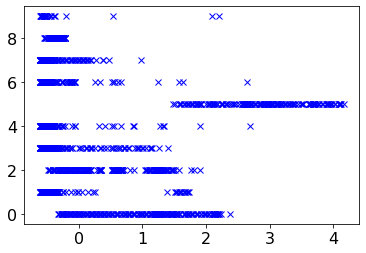

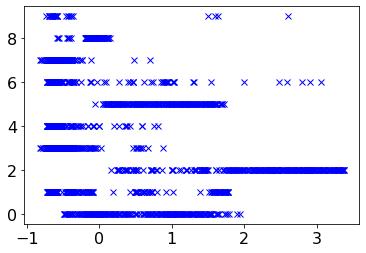

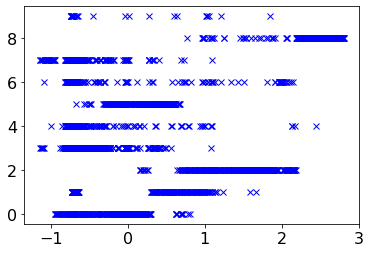

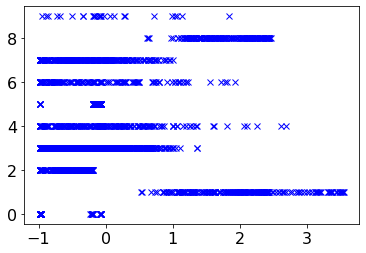

In [43]:
for i in range(xkm.shape[-1]):
    plt.figure
    plt.plot(xkm[:,i], kmTime.labels_, 'bx')
    plt.show()


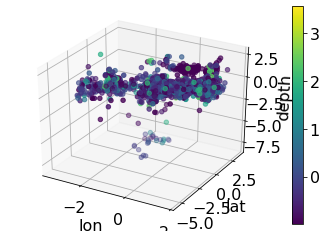

In [44]:
from mpl_toolkits.mplot3d import axes3d
fig = plt.figure()
ax = fig.gca(projection='3d')
p = ax.scatter(xkm[:,0], xkm[:,1], -xkm[:,2], c=xkm[:,-1], marker='o')
ax.set_xlabel('lon')
ax.set_ylabel('lat')
ax.set_zlabel('depth')
fig.colorbar(p)
plt.show()

In [45]:

print('\n Training')
cval, ytrainkm = GetNearestCentroid(x_train, kmTime.cluster_centers_[:,0:7], kmTime.cluster_centers_[:,-1])
CalcRMS(TimeToEruptionScaled[train_idx]-ytrainkm)
print(metrics.r2_score(TimeToEruptionScaled[train_idx],ytrainkm))

print('\n Dev')
cval, yvalkm = GetNearestCentroid(x_val, kmTime.cluster_centers_[:,0:7], kmTime.cluster_centers_[:,-1])
CalcRMS(TimeToEruptionScaled[val_idx]-yvalkm)
print(metrics.r2_score(TimeToEruptionScaled[val_idx],yvalkm))

print('\n test')
cval, ytestkm = GetNearestCentroid(x_test, kmTime.cluster_centers_[:,0:7], kmTime.cluster_centers_[:,-1])
CalcRMS(TimeToEruptionScaled[test_idx]-ytestkm)
print(metrics.r2_score(TimeToEruptionScaled[test_idx],ytestkm))


 Training
rms =  0.951524600524569
0.09518667284451365

 Dev
rms =  0.9464057923392403
0.06068043033611259

 test
rms =  1.0219228807468679
0.03803538035806975


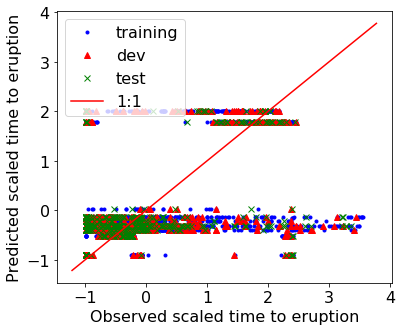

In [53]:
plt.figure(figsize=(6,5))
plt.plot(TimeToEruptionScaled[train_idx], ytrainkm, 'b.', label='training')
plt.plot(TimeToEruptionScaled[val_idx], yvalkm, 'r^', label='dev')
plt.plot(TimeToEruptionScaled[test_idx], ytestkm, 'gx', label='test')
plt.plot(plt.xlim(), plt.xlim(), 'r-', label='1:1')
plt.legend(loc='upper left')
plt.xlabel('Observed scaled time to eruption')
plt.ylabel('Predicted scaled time to eruption')
plt.savefig('ObservedPredictedKmeans.png')
plt.show()
